<a href="https://colab.research.google.com/github/johanhoffman/DD2365-VT20/blob/LindeBee/Project/projectV4_P2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The Navier-Stokes equations**
**Johan Hoffman**

# **Abstract**

This short report show an example on how to use FEniCS to solve the Navier-Stokes equations, which is used in the course DD2365 Advanced Computation in Fluid Mechanics, at the KTH Royal Institute of Technology.

[DD2365 course website.](https://kth.instructure.com/courses/17071)

# **About the code**

In [65]:
"""This program is an example file for the course"""
"""DD2365 Advanced Computation in Fluid Mechanics, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2020 Johan Hoffman (jhoffman@kth.se)

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

In [0]:
# Load neccessary modules.
from google.colab import files

import numpy as np
import time

try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common 
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    from dolfin import *; from mshr import *
    
import dolfin.common.plotting as fenicsplot
import math

from matplotlib import pyplot as plt

# **Introduction**

The Navier-Stokes equations take the form

$\dot u + (u\cdot \nabla)u + \nabla p -\Delta u = f,\quad \nabla \cdot u=0,$

together with suitable initial and boundary conditions.

Here we present a FEniCS implementation of a stabilized space-time finite element method to solve the Navier-Stokes equations in 2D. The solution is visualized using FEniCS plotting functions, and is also exported as pvd-files which can be visualized in Paraview.

We seek a finite element approximation $(u,p)\in V\times Q$ such that 

$(\dot u + (u\cdot \nabla)u, v) - (p,\nabla \cdot v) + (\nu \nabla u,\nabla v) + (\nabla \cdot u, q) + SD(u,p;v,q) = (f,v),$

for all test functions $(v,q) \in \hat V\times \hat Q$, where $SD(u,p;v,q)$ is a residual based stabilization term.

We present an example of flow past a circular cylinder, for which we compute the force on the surface of the cylinder $\Gamma$ in the direction $\phi$, by Green's formula: 

$
F(u,p,\phi)= ~<\nu \nabla u\cdot n-pn, \Phi>_{\Gamma} ~=~(\dot u+(u\cdot \nabla)u, \Phi) + (\nu \nabla u,\nabla \Phi) - (p,\nabla \cdot\Phi)-(f,\Phi),
$

with $\Phi\in V$ a fuinction for which $\Phi\vert _{\Gamma}=\phi$ and $\Phi\vert_{\partial \Omega \setminus \Gamma}=0$. With $\phi=(1,0)$ we get the drag force $F_D$, and with $\phi=(0,1)$ the lift force $F_L$. The drag and lift coefficients are obtained by normalization, 

$
c_D = \frac{2F_D}{\rho U^2D}, \quad c_L = \frac{2F_L}{\rho U^2D}
$

where $\rho$ is the density (here $\rho=1$), $U$ the characteristic velocity (here $U=1$), and $D$ the characteristic length scale (here $D$ is the diameter of the cylinder). 

The Reynolds number is defined as $Re=\frac{UD}{\nu}$

To read more about how to use similar methods for more complex problems, see e.g. 

[Hoffman, Johan, et al. "Towards a parameter-free method for high reynolds number turbulent flow simulation based on adaptive finite element approximation." Computer Methods in Applied Mechanics and Engineering 288 (2015): 60-74.](https://www.sciencedirect.com/science/article/pii/S0045782514004836)


# **Method**

**Define 3 different domains**

*   4 by 4 perpendicular grid
*   diamond grid
*   Concentric circular grid

**Define domain and mesh**

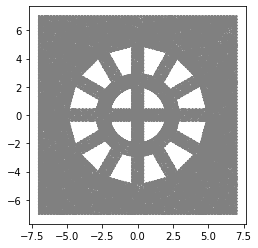

In [67]:
# Define rectangular domain 
L = 14
H = 14

# Generate mesh (examples with and without a hole in the mesh) 
resolution = 64
mesh = RectangleMesh(Point(0.0, 0.0), Point(L, H), L*resolution, H*resolution)
mesh_file = File('mesh.xml')
mesh_file >> mesh

# Local mesh refinement (specified by a cell marker)
no_levels = 0
for i in range(0,no_levels):
  cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
  for cell in cells(mesh):
    cell_marker[cell] = False
    p = cell.midpoint()
    if p.distance(Point(xc, yc)) < 0.5:
        cell_marker[cell] = True
  mesh = refine(mesh, cell_marker)

plt.figure()
plot(mesh)
plt.show()

**Define finite element approximation spaces**

In [0]:
# Generate finite element spaces (for velocity and pressure)
V = VectorFunctionSpace(mesh, "Lagrange", 1)
Q = FunctionSpace(mesh, "Lagrange", 1)

# Define trial and test functions 
u = TrialFunction(V)
p = TrialFunction(Q)
v = TestFunction(V)
q = TestFunction(Q)

**Define boundary conditions**

In [0]:
# # inflow and outflow conditions
XMIN = -7; XMAX = 7
YMIN = -7; YMAX = 7

# # define uin of size 1 for different angles: 0, pi/6, pi/3, pi/2
# # angle = 0
# # uin_x = cos(angle)
# # uin_y = sin(angle)
# # uin = Expression(("uin_x", "uin_y"), uin_x=uin_x, uin_y=uin_y, element = V.ufl_element()) 
# # pin = Expression('5.0*fabs(sin(t))', element = Q.ufl_element(), t=0.0)
# # pout = 0.0

# # Inflow boundary (ib), outflow boundary (ob) and wall boundary (wb)
ib = Expression("near(x[0],XMIN) ? 1. : 0.", XMIN=XMIN, YMIN=YMIN, element = Q.ufl_element())
# ob = Expression("near(x[0],XMAX) || near(x[1], YMAX) ? 1. : 0.", XMAX=XMAX, YMAX=YMAX, element = Q.ufl_element()) 
# wb = Expression("x[0] > XMIN + DOLFIN_EPS && x[0] < XMAX - DOLFIN_EPS && x[1] > YMIN + DOLFIN_EPS && x[1] < YMAX - DOLFIN_EPS? 1. : 0.", XMIN=XMIN, XMAX=XMAX, YMIN=YMIN,YMAX=YMAX, element = Q.ufl_element())

# **Results**

**Define flow parameters**

**Define method parameters**

**Define variational problem**

**Compute force on boundary**

**Set plotting variables and open export files**

**Time stepping algorithm**

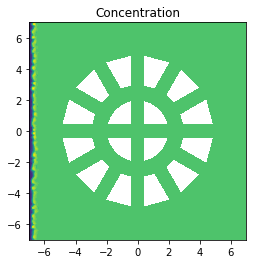

0.00018516778621319668


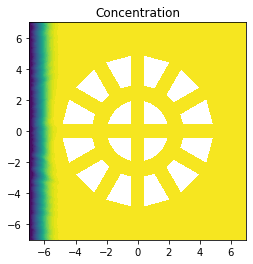

0.018011998254678828


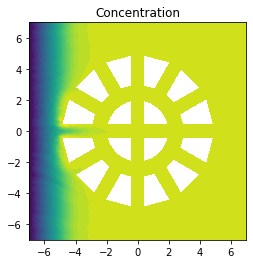

0.03374888653988547


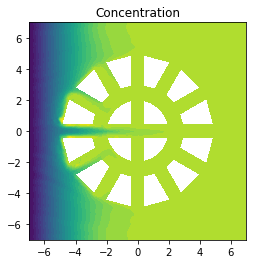

0.04751741062525626


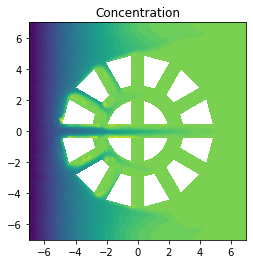

0.05905438338127047


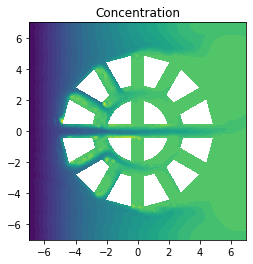

0.06852685513072246


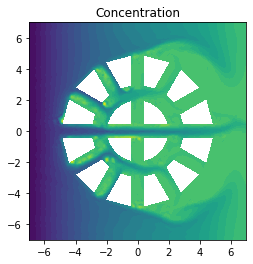

0.07606126163941485


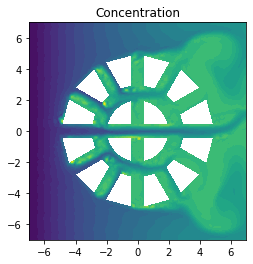

0.08254257849205072


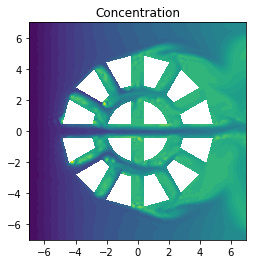

0.08787222837821408


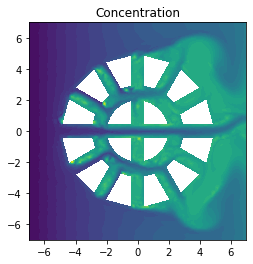

0.09243345661557324


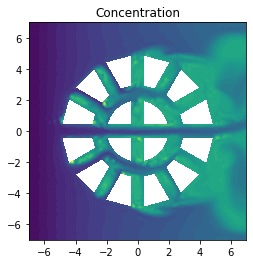

0.09762878320904814


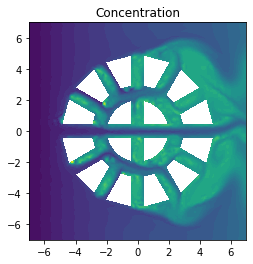

0.10024096666985519


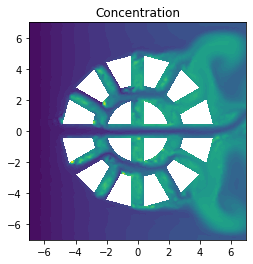

0.10550694688140214


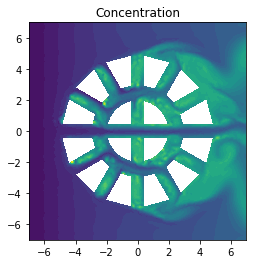

0.10720828789717077


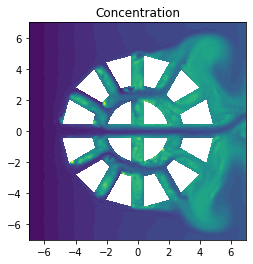

0.11060872685207147


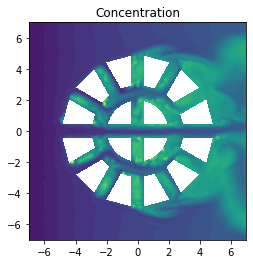

0.11369337213982895


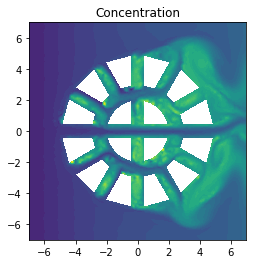

0.11455818221257498


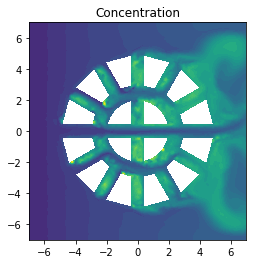

0.11903841097276499


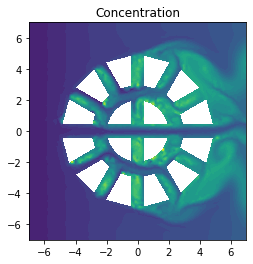

0.11857180025994865


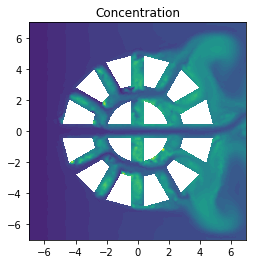

0.12240772401352504


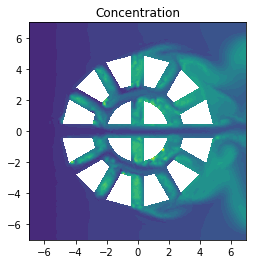

0.12316689078470265


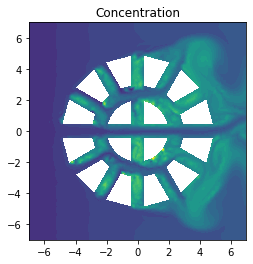

0.12408284656667169


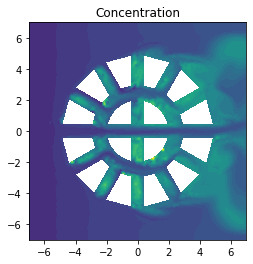

0.1273923190770279


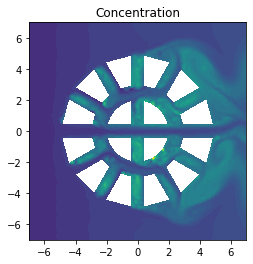

0.12600514472264038


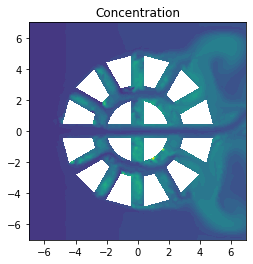

0.13032537567111405


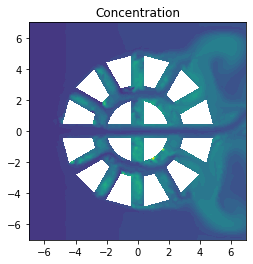

results/
results/c000003.vtu
results/c000023.vtu
results/c000004.vtu
results/c000017.vtu
results/c000018.vtu
results/u000016.vtu
results/u000018.vtu
results/c000009.vtu
results/c.pvd
results/u000013.vtu
results/u000020.vtu
results/u000022.vtu
results/c000012.vtu
results/u000014.vtu
results/u000015.vtu
results/c000000.vtu
results/c000014.vtu
results/c000010.vtu
results/c000021.vtu
results/c000011.vtu
results/c000002.vtu
results/u000006.vtu
results/u000011.vtu
results/u000007.vtu
results/u000003.vtu
results/c000013.vtu
results/c000006.vtu
results/c000020.vtu
results/u000024.vtu
results/u000000.vtu
results/u000009.vtu
results/u000017.vtu
results/c000019.vtu
results/u000008.vtu
results/u000004.vtu
results/u000012.vtu
results/c000007.vtu
results/u000023.vtu
results/u000005.vtu
results/u000010.vtu
results/u000002.vtu
results/c000005.vtu
results/c000024.vtu
results/c000022.vtu
results/u000001.vtu
results/c000015.vtu
results/u000021.vtu
results/c000008.vtu
results/u.pvd
results/c000001.vtu
res

In [70]:
!rm results/*

# Define function space for system of concentrations
u = Function(V)
element = FiniteElement("P", triangle, 1)
Vc = FunctionSpace(mesh, element)

vc = TestFunction(Vc) #test function
fc = Constant(1/mesh.num_cells())    #source
dt = 0.5*mesh.hmin()  #time step
c = Function(Vc)       #concentration
c_n = Function(Vc)     #concentration previous timestep
d = mesh.hmin()

h = CellDiameter(mesh)
C = 1.0e3
gamma = C/h


#variational problem:
Fc = inner((c-c_n)/dt,vc)*dx + inner(dot(u,grad(c)),vc)*dx \
+ gamma*ib*inner(c,vc)*dx + d*dot(u,grad(c))*dot(u,grad(vc))*dx - fc*vc*dx

#time stepping
file_c = File("results/c.pvd")
file_u = File("results/u.pvd")
timeseries_u = TimeSeries('velocity_series')

t=0
T=30
freq = 24
pl = 0
num_steps = int(5/dt)
while t < T + DOLFIN_EPS:
    # print(n+"\n")
    # Update current time
    t += dt
    timeseries_u.retrieve(u.vector(), t%3)
    # Solve variational problem for time step
    solve(Fc == 0, c)
    # Update previous solution
    c_n.assign(c)

    if t > pl: 
      pl += T/freq
      c1 = project(c, Vc)
      plt.figure()
      plot(c1, title="Concentration")
      plt.show()
      # Save solution to file (VTK)
      file_c << (c, t)
      file_u << (u, t)
      print(assemble(c*dx))

# Plot solution
c1 = project(c, Vc)
plt.figure()
plot(c1, title="Concentration")
plt.show()

!tar -czvf results.tar.gz results
files.download('results.tar.gz')


In [0]:
# # Save solution
# u_sol = project(u_mean,V)
# output_file = HDF5File(mesh.mpi_comm(), "u_c_0.h5", "w")
# output_file.write(u_sol, "solution")
# output_file.close()

# Load solution
# U = Function(V)
# input_file = HDF5File(mesh.mpi_comm(), "u.h5", "r")
# input_file.read(U, "solution")
# input_file.close()

# **Discussion**

A stabilized finite element method was implemented in FEniCS to solve the Navier-Stokes equations in 2D. The method was tested for the model problem of flow past a circular obstacle, and for a high enough Reynolds number and sufficient mesh resolution [a von Karman vortex street developed as expected.](https://en.wikipedia.org/wiki/Kármán_vortex_street)